In [14]:
# Cell 1: Imports, configuration, device

import os
import random

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)

# Repro / training hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 256
LR = 1e-2
N_EPOCHS = 50

# Path to your CSV (Windows folder seen from WSL)
BASE_DIR = "/mnt/c/Users/Home/Documents/PBA_Assignment"
csv_path = os.path.join(BASE_DIR, "data_model_preprocessing-PBA.csv")

print("CSV path:", csv_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CSV path: /mnt/c/Users/Home/Documents/PBA_Assignment/data_model_preprocessing-PBA.csv
Using device: cuda


In [15]:
# Cell 2: Seed, load dataframe, inspect

def set_seed(seed: int = RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}")

df = pd.read_csv(csv_path)

print("Shape:", df.shape)
print("\nColumns:")
for c in df.columns:
    print(" -", c)

df.head()



Shape: (122557, 31)

Columns:
 - WeekendOrder
 - Processing.Days
 - Distance_km
 - `Order Item Product Price`
 - `Order Item Quantity`
 - `Order Item Discount Rate`
 - `Order Region`Caribbean
 - `Order Region`Central Africa
 - `Order Region`Central America
 - `Order Region`East Africa
 - `Order Region`East of USA
 - `Order Region`Eastern Asia
 - `Order Region`Eastern Europe
 - `Order Region`North Africa
 - `Order Region`Northern Europe
 - `Order Region`Oceania
 - `Order Region`South America
 - `Order Region`South Asia
 - `Order Region`South of  USA
 - `Order Region`Southeast Asia
 - `Order Region`Southern Africa
 - `Order Region`Southern Europe
 - `Order Region`US Center
 - `Order Region`West Africa
 - `Order Region`West Asia
 - `Order Region`West of USA
 - `Order Region`Western Europe
 - `Shipping Mode`Same Day
 - `Shipping Mode`Second Class
 - `Shipping Mode`Standard Class
 - Late_delivery_risk


,WeekendOrder,Processing.Days,Distance_km,`Order Item Product Price`,`Order Item Quantity`,`Order Item Discount Rate`,`Order Region`Caribbean,`Order Region`Central Africa,`Order Region`Central America,`Order Region`East Africa,...,`Order Region`Southern Europe,`Order Region`US Center,`Order Region`West Africa,`Order Region`West Asia,`Order Region`West of USA,`Order Region`Western Europe,`Shipping Mode`Same Day,`Shipping Mode`Second Class,`Shipping Mode`Standard Class,Late_delivery_risk
0,0,3.0,18500.760815,327.75,1,0.04,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,3.0,11640.755465,327.75,1,0.07,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,2.0,16576.993966,327.75,1,0.09,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,6.0,15192.036863,327.75,1,0.10,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2.0,15431.281031,327.75,1,0.12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Cell 3: Define target and feature matrix

TARGET_COL = "Late_delivery_risk"

if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataframe.")

# Basic check of target distribution
print("Target value counts:")
print(df[TARGET_COL].value_counts())

# Exclude target and any pure IDs if present
ID_CANDIDATES = ["OrderId", "Order Id", "order_id"]
id_cols = [c for c in ID_CANDIDATES if c in df.columns]

exclude_cols = [TARGET_COL] + id_cols
feature_cols = [c for c in df.columns if c not in exclude_cols]

print("\nID columns being excluded:", id_cols)
print("Number of features:", len(feature_cols))
print("First 10 features:", feature_cols[:10])

# Build X and y
X = df[feature_cols].copy()

# Ensure numeric and handle any remaining NaNs
X = X.apply(pd.to_numeric, errors="coerce")
if X.isna().any().any():
    X = X.fillna(X.mean())

X = X.values.astype(np.float32)

# y as 0/1 floats
y = df[TARGET_COL].astype(float).values

print("X shape:", X.shape)
print("y shape:", y.shape)



Target value counts:
Late_delivery_risk
1    67236
0    55321
Name: count, dtype: int64

ID columns being excluded: []
Number of features: 30
First 10 features: ['WeekendOrder', 'Processing.Days', 'Distance_km', '`Order Item Product Price`', '`Order Item Quantity`', '`Order Item Discount Rate`', '`Order Region`Caribbean', '`Order Region`Central Africa', '`Order Region`Central America', '`Order Region`East Africa']
X shape: (122557, 30)
y shape: (122557,)


In [17]:
# Cell 4: Train / validation / test split

n_samples = X.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)

train_end = int(0.6 * n_samples)
val_end = int(0.8 * n_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train size:", X_train.shape[0])
print("Val size  :", X_val.shape[0])
print("Test size :", X_test.shape[0])

print("\nTrain class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))


Train size: 73534
Val size  : 24511
Test size : 24512

Train class distribution:
1.0    0.546876
0.0    0.453124
Name: proportion, dtype: float64


In [18]:
# Cell 5: Standardisation (fit on train only)

x_mean = X_train.mean(axis=0, keepdims=True)
x_std  = X_train.std(axis=0, keepdims=True)
x_std[x_std == 0] = 1.0

X_train_norm = (X_train - x_mean) / x_std
X_val_norm   = (X_val   - x_mean) / x_std
X_test_norm  = (X_test  - x_mean) / x_std

print("Normalised shapes:", X_train_norm.shape, X_val_norm.shape, X_test_norm.shape)



Normalised shapes: (73534, 30) (24511, 30) (24512, 30)


In [19]:
# Cell 6: PyTorch Dataset and DataLoader

class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train_norm, y_train)
val_ds   = TabularDataset(X_val_norm,   y_val)
test_ds  = TabularDataset(X_test_norm,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(73534, 24511, 24512)

In [20]:
# Cell 7: Logistic regression model (linear + sigmoid) and training

class LogisticRegressionModel(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.linear(x)          # (batch, 1)
        return logits.squeeze(1)         # (batch,)

n_features = X_train_norm.shape[1]
model = LogisticRegressionModel(n_features).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)


LogisticRegressionModel(
  (linear): Linear(in_features=30, out_features=1, bias=True)
)


In [10]:
def run_epoch(dataloader, model, criterion, optimizer=None):
    """
    If optimizer is provided → training mode.
    If optimizer is None     → evaluation mode.
    Returns avg loss and stacked logits/targets.
    """
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n_samples = 0
    all_logits = []
    all_targets = []

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_size = X_batch.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

        all_logits.append(logits.detach().cpu().numpy())
        all_targets.append(y_batch.detach().cpu().numpy())

    avg_loss = total_loss / max(n_samples, 1)
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_logits, all_targets


train_history = []
val_history = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss, _, _ = run_epoch(train_loader, model, criterion, optimizer)
    val_loss,   _, _ = run_epoch(val_loader,   model, criterion, optimizer=None)

    train_history.append(train_loss)
    val_history.append(val_loss)

    if epoch == 1 or epoch % 10 == 0 or epoch == N_EPOCHS:
        print(f"Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


Epoch 001 | Train loss: 0.4026 | Val loss: 0.2961
Epoch 010 | Train loss: 0.1900 | Val loss: 0.2011
Epoch 020 | Train loss: 0.1895 | Val loss: 0.2001
Epoch 030 | Train loss: 0.1895 | Val loss: 0.1995
Epoch 040 | Train loss: 0.1897 | Val loss: 0.1999
Epoch 050 | Train loss: 0.1897 | Val loss: 0.1995


In [11]:
# Cell 8: Classification metrics helper

def compute_classification_metrics(y_true, logits, threshold=0.5):
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
    }


In [12]:
# Cell 9: Evaluate logistic regression baseline

# Train
_, train_logits, train_targets = run_epoch(train_loader, model, criterion, optimizer=None)
train_metrics = compute_classification_metrics(train_targets, train_logits)

# Val
_, val_logits, val_targets = run_epoch(val_loader, model, criterion, optimizer=None)
val_metrics = compute_classification_metrics(val_targets, val_logits)

# Test
_, test_logits, test_targets = run_epoch(test_loader, model, criterion, optimizer=None)
test_metrics = compute_classification_metrics(test_targets, test_logits)

print("Train metrics:", train_metrics)
print("\nVal metrics:", val_metrics)
print("\nTest metrics:", test_metrics)

Train metrics: {'accuracy': 0.951723012484021, 'precision': 0.9562241799810861, 'recall': 0.9554632714974884, 'f1': 0.9558435743071795, 'roc_auc': 0.972715407593385, 'confusion_matrix': array([[31561,  1759],
       [ 1791, 38423]])}

Val metrics: {'accuracy': 0.9507568030680102, 'precision': 0.9551381215469613, 'recall': 0.9559127101150103, 'f1': 0.9555252588525738, 'roc_auc': 0.9703576435422736, 'confusion_matrix': array([[10338,   609],
       [  598, 12966]])}

Test metrics: {'accuracy': 0.9529618146214099, 'precision': 0.9584233663661426, 'recall': 0.9557883786595334, 'f1': 0.9571040589307638, 'roc_auc': 0.9738136858943153, 'confusion_matrix': array([[10496,   558],
       [  595, 12863]])}


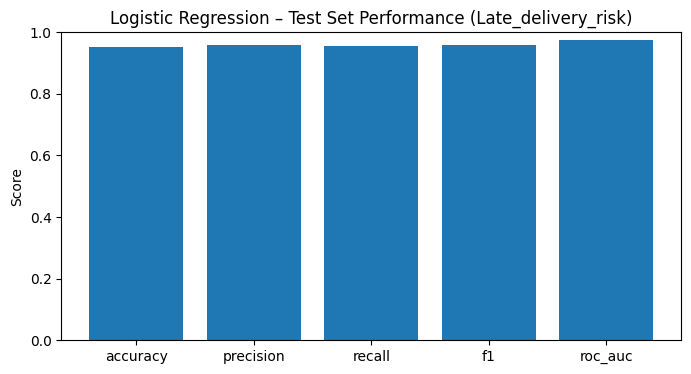

In [13]:
# Cell 10: Visualise test-set performance

metrics_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
values = [test_metrics[m] for m in metrics_names]

plt.figure(figsize=(8, 4))
plt.bar(metrics_names, values)
plt.ylim(0, 1)
plt.title("Logistic Regression – Test Set Performance (Late_delivery_risk)")
plt.ylabel("Score")
plt.show()

In [21]:
# Cell 11: Extract logistic regression coefficients

# Get weights and bias from the trained model
logit_weights = model.linear.weight.detach().cpu().numpy().flatten()
logit_bias = model.linear.bias.item()

coef_logit_df = pd.DataFrame({
    "feature": feature_cols,
    "weight": logit_weights
})

print("Intercept (bias):", logit_bias)
coef_logit_df.head()


Intercept (bias): 0.16488440334796906


,feature,weight
0,WeekendOrder,0.139585
1,Processing.Days,0.151538
2,Distance_km,-0.042772
3,`Order Item Product Price`,0.167715
4,`Order Item Quantity`,-0.040003


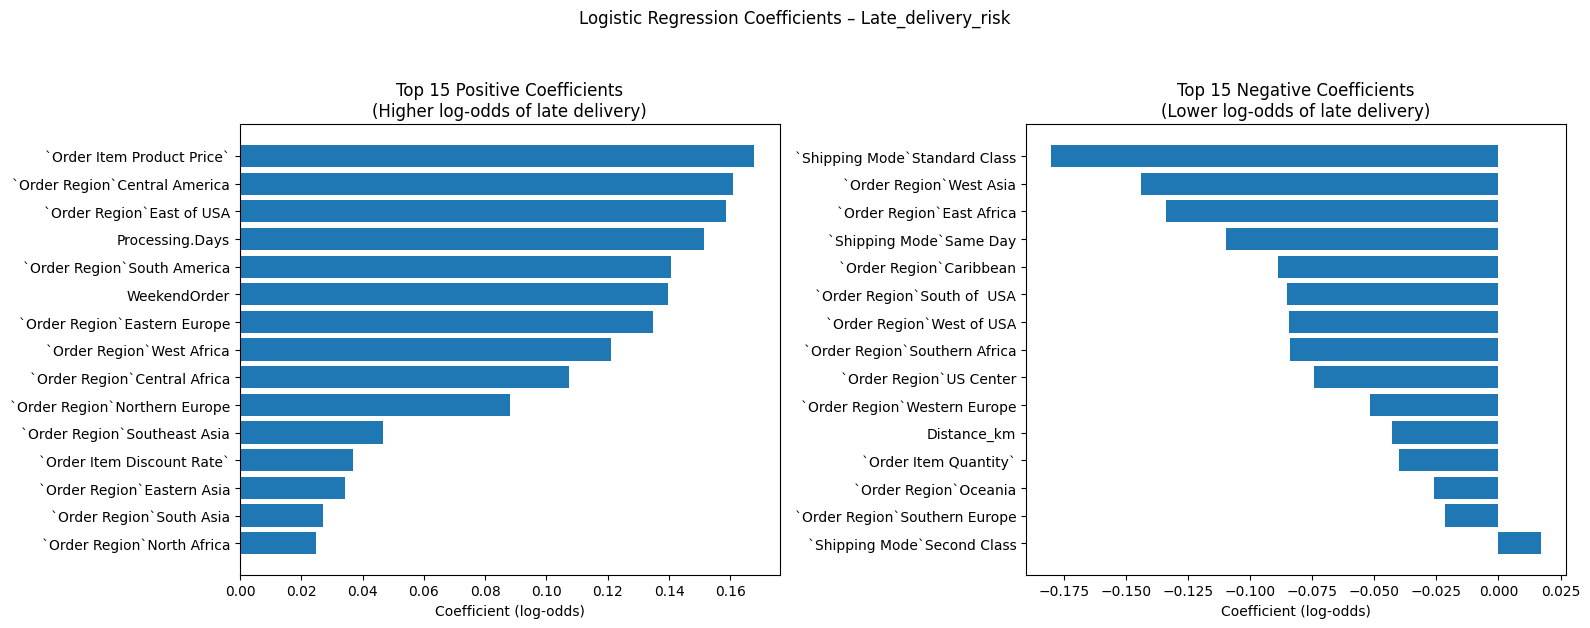

In [22]:
# Cell 12: Plotting top positive and negative coefficients

# Sort by coefficient value
coef_logit_sorted = coef_logit_df.sort_values("weight", ascending=False)

top_n = 15  # how many to show on each side

top_pos = coef_logit_sorted.head(top_n)                         # largest positive
top_neg = coef_logit_sorted.tail(top_n).sort_values("weight")   # most negative

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: features that *increase* late-delivery risk
axes[0].barh(top_pos["feature"], top_pos["weight"])
axes[0].set_title(f"Top {top_n} Positive Coefficients\n(Higher log-odds of late delivery)")
axes[0].set_xlabel("Coefficient (log-odds)")
axes[0].invert_yaxis()  # biggest at top

# Right panel: features that *decrease* late-delivery risk
axes[1].barh(top_neg["feature"], top_neg["weight"])
axes[1].set_title(f"Top {top_n} Negative Coefficients\n(Lower log-odds of late delivery)")
axes[1].set_xlabel("Coefficient (log-odds)")
axes[1].invert_yaxis()

plt.suptitle("Logistic Regression Coefficients – Late_delivery_risk", y=1.04)
plt.tight_layout()
plt.show()


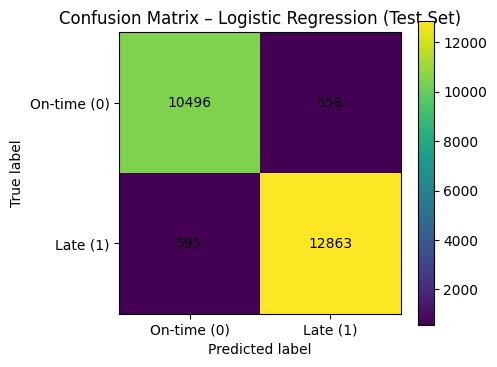

In [23]:
# The confusion matrix
import matplotlib.pyplot as plt

cm = test_metrics["confusion_matrix"]

classes = ["On-time (0)", "Late (1)"]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")

# Add a colorbar
plt.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Logistic Regression (Test Set)")

# Annotate each cell with the count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            str(cm[i, j]),
            ha="center",
            va="center"
        )

plt.tight_layout()
plt.show()
